In [1]:
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from sklearn.metrics import accuracy_score
import itertools
from scipy import linalg

%matplotlib inline

# Create dataset`s

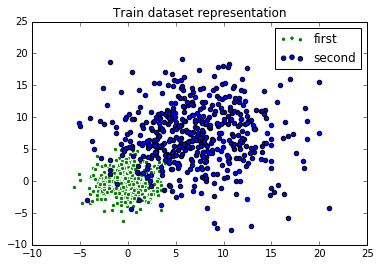

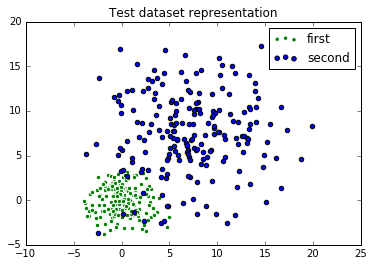

In [2]:
###################
# First dataset
###################

v = 7
middle_f = (0,0)
cov_matrix_f = np.array(([v / 2, 0 ], [0, v/2]))

firstSet =  np.random.multivariate_normal(middle_f, cov_matrix_f, 500)
firstSetTest =  np.random.multivariate_normal(middle_f, cov_matrix_f, 200)

##############################################################
middle_s = (v, v)
cov_matrix_s = np.array(([3*v, 0 ], [0, 3*v]))

secondSet = np.random.multivariate_normal(middle_s, cov_matrix_s, 500)
secondSetTest = np.random.multivariate_normal(middle_s, cov_matrix_s, 200)

x_train = np.concatenate((firstSet, secondSet))
y_train = np.concatenate([np.zeros((500)), np.ones((500))]).astype('int')

x_test = np.concatenate( [ firstSetTest, secondSetTest] )
y_test = np.concatenate([np.zeros((200)), np.ones((200))]).astype('int')


plt.title('Train dataset representation')
plt.scatter(firstSet[:, 0],  firstSet[:, 1],color = 'green', edgecolors = 'white', label = 'first')
plt.scatter(secondSet[:, 0],  secondSet[:, 1], label = 'second')
plt.legend()
plt.show()


plt.title('Test dataset representation')
plt.scatter(firstSetTest[:, 0],  firstSetTest[:, 1],color = 'green', edgecolors = 'white', label = 'first')
plt.scatter(secondSetTest[:, 0],  secondSetTest[:, 1], label = 'second')
plt.legend()
plt.show()

In [3]:
covar_type = 'diag'
i = 4

g1 =  GMM(n_components = i, covariance_type='full', init_params='wmc', n_iter=100)
g1.fit(firstSet)
g2 =  GMM(n_components = i, covariance_type=covar_type, init_params='wmc', n_iter=100)
g2.fit(secondSet)

prediction  = np.array(np.log(firstSet.shape[0])+ g1.score(x_test)  < np.log(secondSet.shape[0])+g2.score(x_test)).astype('int')

accuracy = np.mean(prediction == y_test) * 100
print 'gaussian kernels = %d, accuracy = %f'%(i, accuracy)

gaussian kernels = 4, accuracy = 96.750000


# Create MAP-adaptaion for ubm model

In [4]:
def computeUBM(ubm_model, data):
    
    ###########################################
    # ubm_model - gmm-represent distribution of our model
    # data - samples, which will correct ubm-model
    ###############################################
    
    xdim = data.shape[1]
    M = ubm_model.n_components
    
    ###############################################################   
    #    ubm_means: means of the ubm <number array>               #
    #    ubm_covars: covariances of the ubm <number array>        #
    #    ubm_weights: weights of the ubm <number array>           #
    #    new_means: means adapted from the ubm <number array>     #
    #    new_weights: weights adapted from the ubm <number array> #
    ###############################################################    
        
    # Copy parameters GMM-model
    ubm_weights = ubm_model.weights_
    ubm_means = ubm_model.means_
    ubm_covars = ubm_model.covars_
           
    ###################################################################
    # for X = {x_1, ..., x_T}                                         # 
    # P(i|x_t) = w_i * p_i(x_t) / sum_j=1_M(w_j * P_j(x_t))           #
    ###################################################################
    
    posterior_prob = ubm_model.predict_proba(data)
    pr_i_xt = (ubm_weights * posterior_prob)/ np.asmatrix(np.sum(ubm_weights \
                                                * posterior_prob, axis = 1)).T

    n_i = np.asarray(np.sum(pr_i_xt, axis = 0)).flatten() # [M, ]
    
    # Then we can compute E(x) and E(x2) and calculate new parameters of
    # our model
    
    E_x = np.asarray([(np.asarray(pr_i_xt[:, i]) * data).sum(axis = 0) / n_i[i] for i in range(M)]) # [M x xdim]  
    E_x2 = np.asarray([(np.asarray(pr_i_xt[:, i]) * (data**2)).sum(axis = 0) / n_i[i] for i in range(M)])# [M x xdim]

    ################################################################ 
    #    T: scaling factor, number of samples                      #
    #    relevance_factor: factor for scaling the adapted means    #
    #    scaleparam - scale parameter for weights matrix estimation#
    ################################################################  
    
    T = data.shape[0]   
    relevance_factor = 16
    scaleparam = 1
    
    ################################################################      
    # compute alpha_i: data-depentend apaptation coefficient       #
    # alpha_w = alpha_m = alpha_v                                  #
    # alpha_i = n_i/ (n_i + relevance factor)                      #
    ################################################################
    
    alpha_i = n_i / (n_i + relevance_factor)

    ###############################
    # Parqameter`s adaptation
    ##############################
    new_weights = (alpha_i * n_i / T + (1.0 - alpha_i)* ubm_weights) * scaleparam       
    
    alpha_i = np.asarray(np.asmatrix(alpha_i).T)    
    new_means = (alpha_i * E_x + (1. - alpha_i) * ubm_means)      
    new_covars = alpha_i * E_x2 + (1. - alpha_i) * (ubm_covars + (ubm_means **2)) - (new_means ** 2)

    #############################################
    #if we want compute `full` covariance matrix - comment code here
    #new_covars = np.zeros([M, xdim, xdim])
    #for j in range(M):
    #    new_covars[j] = alpha_i[j]*E_x2[j] +(1. - alpha_i[j]).flatten()*(ubm_covars[j] + (new_means[j]**2))- (ubm_means[j]**2)
    #    new_covars[i] = np.where(new_covars[i] < MIN_VARIANCE, MIN_VARIANCE, new_covars[i])
    ####################################################################
    #   `covars_` : array
    #    Covariance parameters for each mixture component.  The shape
    #    depends on `covariance_type`::
    #        (n_components, n_features)             if 'spherical',
    #        (n_features, n_features)               if 'tied',
    #        (n_components, n_features)             if 'diag',
    #        (n_components, n_features, n_features) if 'full'
    #####################################################################

    
    ubm_model.means_ = new_means
    ubm_model.weights_ = new_weights
    ubm_model.covars_ = new_covars

    return ubm_model


In [5]:
def plotGMM(mixture, data, Y_):

    color_iter = itertools.cycle(['r', 'g', 'm', 'b', 'r'])
    plt.figure(figsize=(20,20)) 
    splot = plt.subplot(2, 1, 1)

    for i, (mean, covar, color) in enumerate(zip(
            mixture.means_, mixture._get_covars(), color_iter)):

        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
                continue

        plt.scatter(x_test[Y_ == i, 0], x_test[Y_ == i, 1], 2, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi 
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        plt.xlim(-5, 5)
        plt.ylim(-3, 3)
    plt.show()

In [6]:
g2 = GMM(n_components=7, covariance_type='diag',init_params='wmc', n_iter=1)
g2.fit(firstSet)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=7, n_init=1, n_iter=1, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 200
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars


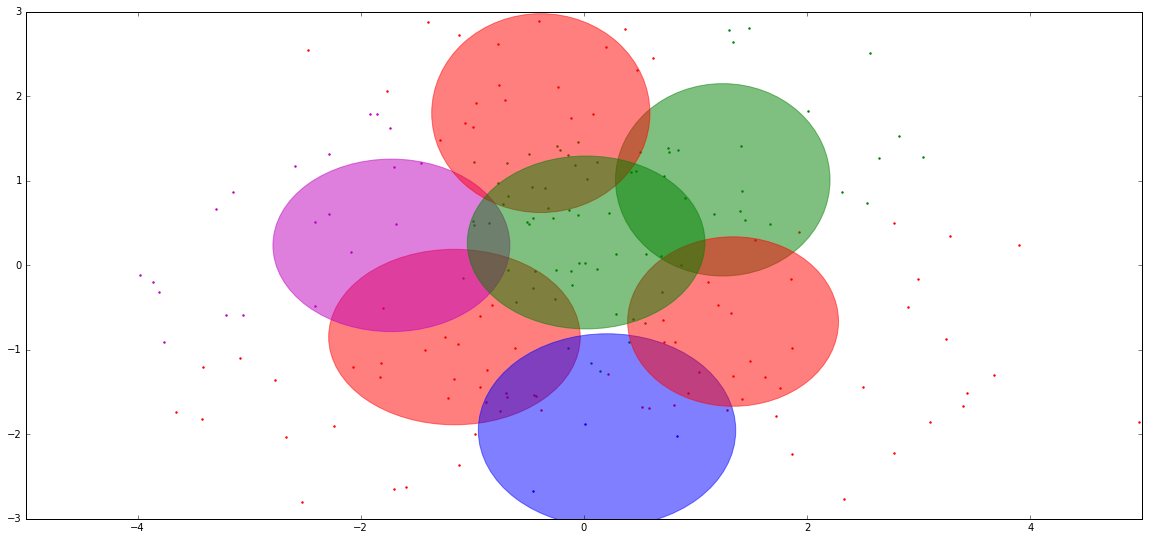

In [7]:
z = g2.predict(firstSetTest)
plotGMM(g2, firstSetTest,z)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 200
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars


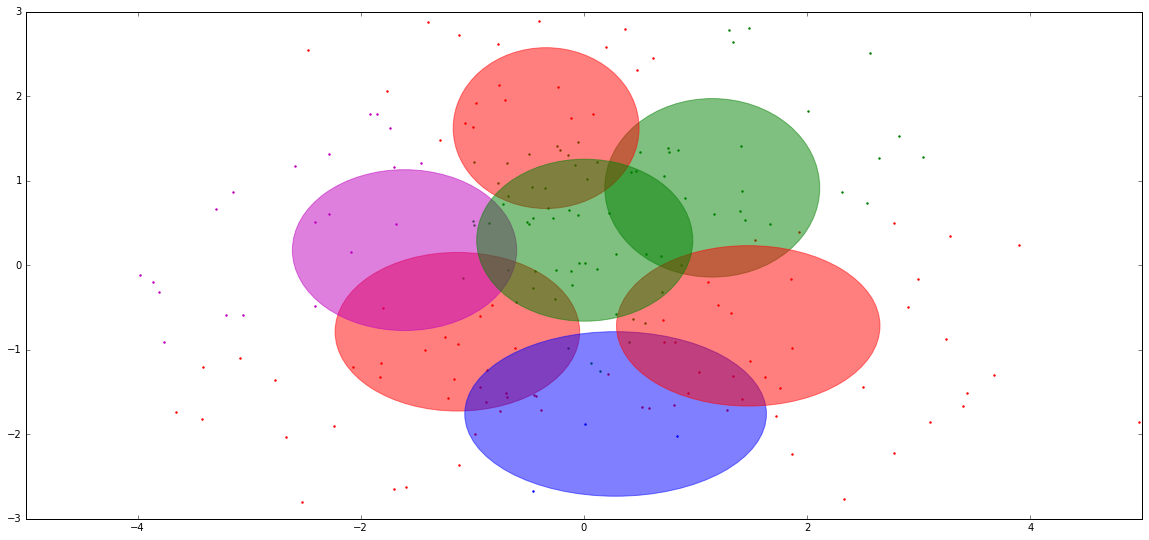

In [8]:
re = computeUBM(g2, firstSetTest)
plotGMM(re, firstSetTest, z)


after 0 iter


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 200
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars


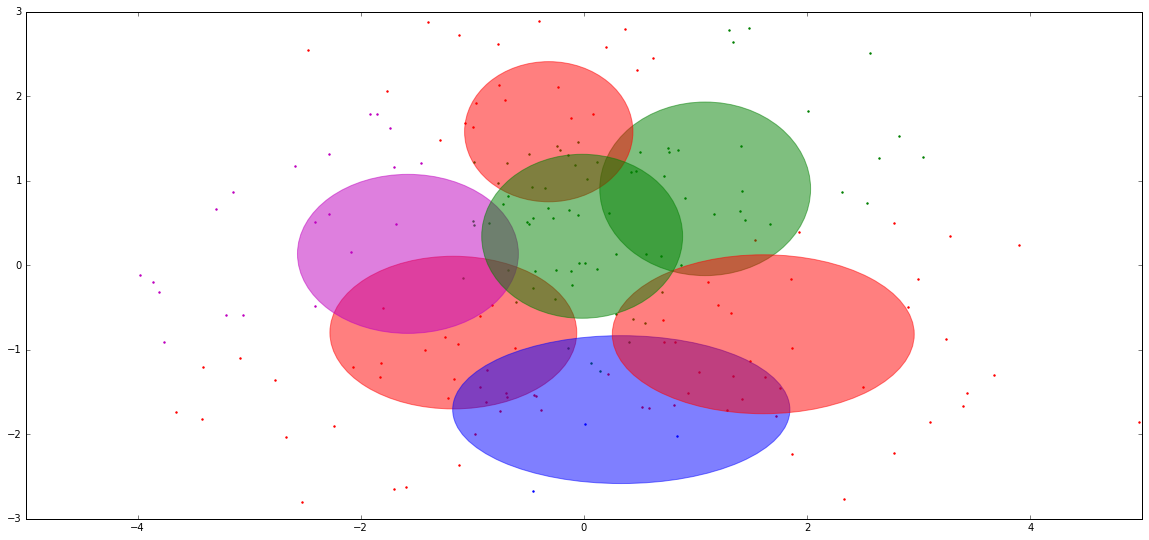

after 1 iter


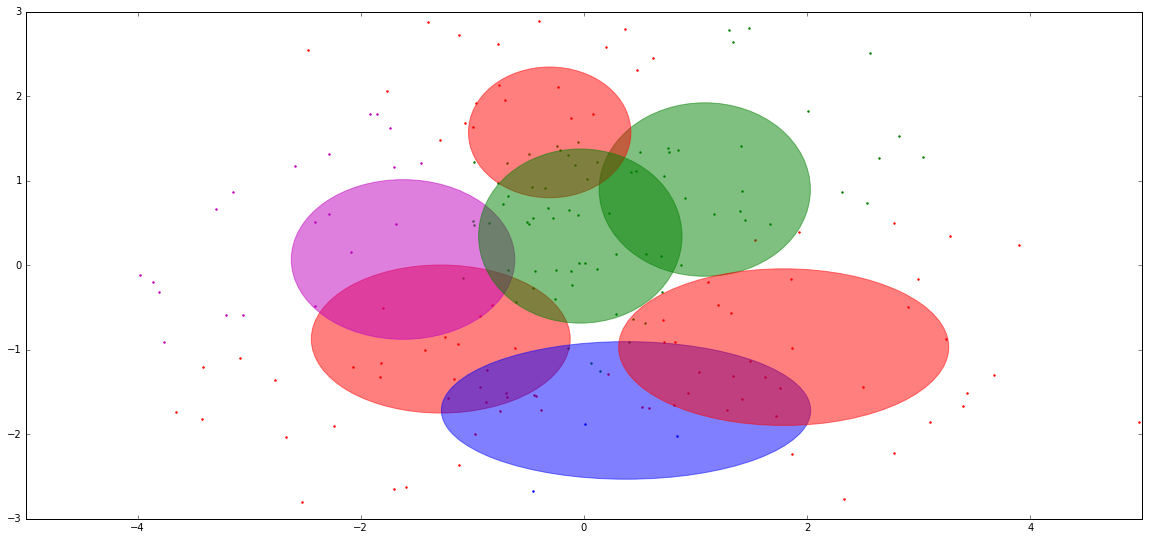

after 2 iter


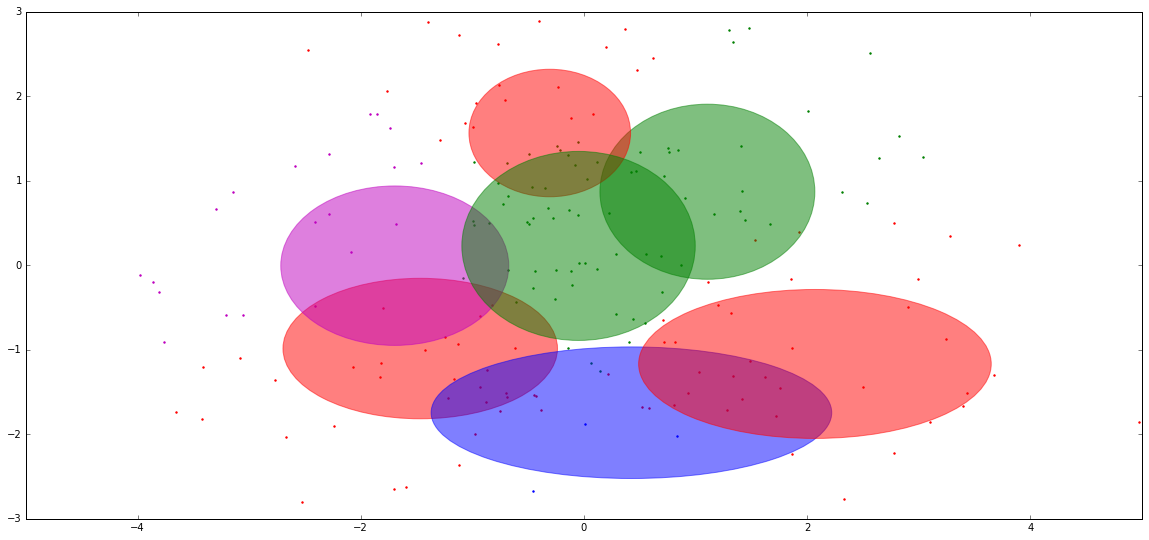

after 3 iter


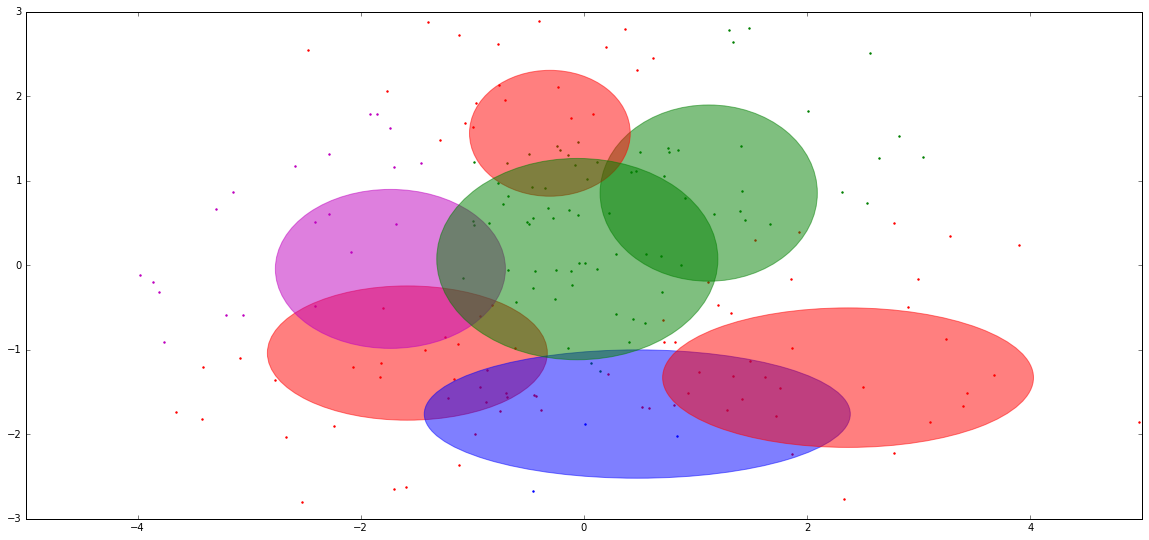

after 4 iter


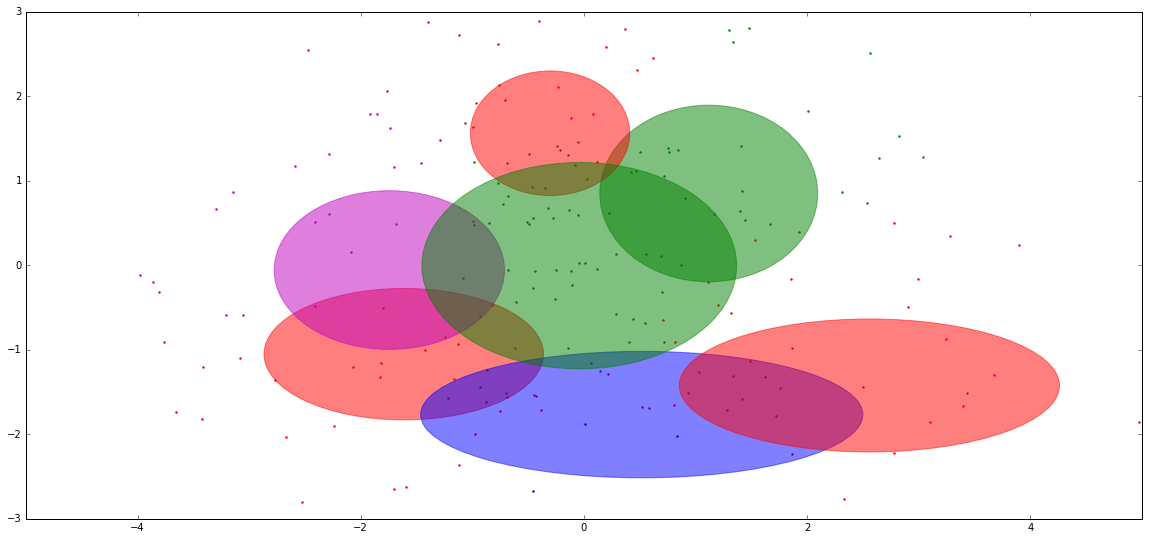

In [9]:
for i in range(5):
    print 'after %d iter' %i
    re = computeUBM(re, firstSetTest)
    plotGMM(re, firstSetTest,z)

In [10]:
com1 =GMM(n_components=7, covariance_type='diag',init_params='wmc', n_iter=1)
com1.fit(firstSet)

com2 =GMM(n_components=7, covariance_type='diag',init_params='wmc', n_iter=1)
com2.fit(secondSet)

prediction  = np.array(np.log(firstSet.shape[0])+ com1.score(x_test)  < np.log(secondSet.shape[0])+com2.score(x_test)).astype('int')
accuracy = np.mean(prediction == y_test) * 100
print accuracy

96.25


In [11]:
com1adapt = computeUBM(com1, firstSetTest)
com2adapt = computeUBM(com2, secondSetTest)

prediction  = np.array(com1adapt.score(x_test)  < com2adapt.score(x_test)).astype('int')
accuracy = np.mean(prediction == y_test) * 100
print '1 iter = ', accuracy

acc = []
for i in range(1,5):
    com2adapt = computeUBM(com2adapt, secondSetTest)
    com1adapt = computeUBM(com1adapt, firstSetTest)
    
    prediction  = np.array(np.log(firstSet.shape[0])+ com1adapt.score(x_test)  < (np.log(secondSet.shape[0])+com2adapt.score(x_test)).astype('int'))
    accuracy = np.mean(prediction == y_test) * 100
    print accuracy
    acc.append(accuracy)
    
print np.max(acc)

1 iter =  96.0
96.0
95.75
96.0
96.0
96.0
